In [1]:
import sys
sys.path.append('..')

In [47]:
from src.features.segment_transcript import CreateBlocks
from src.visualization.visualize import MyPlotting
import glob
import json
import os
import pandas as pd
import ast
import numpy as np

In [114]:
from scipy.ndimage.filters import median_filter

C:\Users\yaniv\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
import gensim.corpora as corpora
import gensim

In [39]:
from scipy.stats import entropy

In [4]:
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')

In [5]:
'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript


In [6]:
transcripts_jsons.keys()

dict_keys(['2mC1uqwEmWQ', 'MkiUBJcgdUY', 'x5zLaWT5KPs', 'zWg7U0OEAoE'])

In [117]:
block_handler =  CreateBlocks(transcripts_jsons['2mC1uqwEmWQ'],window_size=20)
blocks = block_handler.partion_by_sliding_windows(120,20)

In [118]:
id2word = corpora.Dictionary(blocks)
#print(id2word.token2id)

In [119]:
corpus = [id2word.doc2bow(doc) for doc in blocks]
#print(corpus)

In [120]:
# low alpha means each document is only represented by a small number of topics, and vice versa
# low eta means each topic is only represented by a small number of words, and vice versa
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=15, id2word=id2word,
               alpha=1e-5, eta=0.5e-2, chunksize=100, minimum_probability=0.0, passes=2)
#print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")

In [121]:
#lda.show_topics(num_topics=15,num_words=20)

In [122]:
#lda.get_document_topics(bow=corpus[0])

In [123]:
blocks_distributions = np.array([np.array([doc_dis[1] for doc_dis in lda.get_document_topics(bow=cp)]) for cp in corpus] )

In [124]:
blocks_distributions.shape

(58, 15)

In [125]:
def shannon_distance(doc_dist_1,doc_dist_2):
    m = 0.5 * (doc_dist_1 + doc_dist_2)
    return np.square(0.5*(entropy(doc_dist_1,m) + entropy(doc_dist_2,m)))

In [126]:
sh_mat = np.empty(shape=(blocks_distributions.shape[0],blocks_distributions.shape[0]))

In [127]:
for i in range(blocks_distributions.shape[0]):
    for j in range(blocks_distributions.shape[0]):
        sh_mat[i][j] = shannon_distance(blocks_distributions[i],blocks_distributions[j])

In [128]:
sh_mat

array([[0.00000000e+00, 3.30222003e-03, 3.30222003e-03, ...,
        2.15473911e-01, 2.15473911e-01, 2.42885500e-01],
       [3.30222003e-03, 0.00000000e+00, 2.47259531e-27, ...,
        4.80450042e-01, 4.80450042e-01, 4.80449216e-01],
       [3.30222003e-03, 2.47259531e-27, 0.00000000e+00, ...,
        4.80450042e-01, 4.80450042e-01, 4.80449216e-01],
       ...,
       [2.15473911e-01, 4.80450042e-01, 4.80450042e-01, ...,
        0.00000000e+00, 2.47420215e-27, 1.71281074e-02],
       [2.15473911e-01, 4.80450042e-01, 4.80450042e-01, ...,
        2.47420215e-27, 0.00000000e+00, 1.71281074e-02],
       [2.42885500e-01, 4.80449216e-01, 4.80449216e-01, ...,
        1.71281074e-02, 1.71281074e-02, 0.00000000e+00]])

In [129]:
df = pd.DataFrame(sh_mat)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.390665,0.415624,0.415624,0.415624,0.415624,0.415624,0.399189,0.389123,0.432131,0.432131,...,0.413115,0.413115,0.413115,0.413115,0.382837,0.394150,0.427876,0.427876,0.427876,0.430131
std,0.169784,0.163768,0.163768,0.163768,0.163768,0.163768,0.167481,0.173648,0.136497,0.136497,...,0.161119,0.161119,0.161119,0.161119,0.178876,0.162642,0.145483,0.145483,0.145483,0.139933
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480448,0.480449,0.480449,0.480449,0.480449,0.480449,0.480448,0.480448,0.480449,0.480449,...,0.480449,0.480449,0.480449,0.480449,0.480448,0.480448,0.480449,0.480449,0.480449,0.480448
50%,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449,0.480450,0.480450,...,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449,0.480449
75%,0.480449,0.480450,0.480450,0.480450,0.480450,0.480450,0.480449,0.480449,0.480450,0.480450,...,0.480450,0.480450,0.480450,0.480450,0.480449,0.480449,0.480450,0.480450,0.480450,0.480449
max,0.480449,0.480450,0.480450,0.480450,0.480450,0.480450,0.480449,0.480449,0.480450,0.480450,...,0.480450,0.480450,0.480450,0.480450,0.480450,0.480449,0.480450,0.480450,0.480450,0.480449


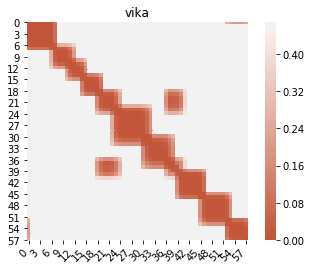

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(sh_mat,vmin=0, vmax=0.468946, center=0.468946,cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_title('vika')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
        
        #if figure_path is not None:
        #    fig_path = os.path.join(figure_path,title + '.png')
        #    plt.savefig(fig_path)
        
plt.show()

In [131]:
sim_mat = median_filter(sh_mat,footprint=np.ones((2,2)))

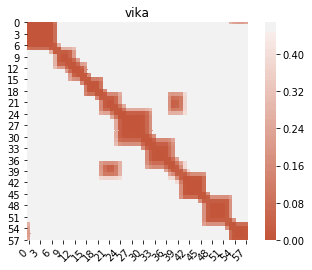

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(sim_mat,vmin=0, vmax=0.468946, center=0.468946,cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_title('vika')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
        
        #if figure_path is not None:
        #    fig_path = os.path.join(figure_path,title + '.png')
        #    plt.savefig(fig_path)
        
plt.show()